In [1]:
import pandas as pd

# Load CSV
df = pd.read_csv("branded_food.csv")

# Peek at the data
df.head()


C:\Users\nifft\AppData\Local\Temp\ipykernel_20764\4230925576.py:4: DtypeWarning: Columns (2,3,4,6,12,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("branded_food.csv")


,fdc_id,brand_owner,brand_name,subbrand_name,gtin_upc,ingredients,not_a_significant_source_of,serving_size,serving_size_unit,household_serving_fulltext,...,data_source,package_weight,modified_date,available_date,market_country,discontinued_date,preparation_state_code,trade_channel,short_description,material_code
0,1105904,Richardson Oilseed Products (US) Limited,NaN,NaN,27000612323,Vegetable Oil,NaN,15.0,ml,1 Tbsp (15 ml),...,GDSN,NaN,2020-10-02,2020-11-13,United States,NaN,NaN,NaN,NaN,NaN
1,1105905,CAMPBELL SOUP COMPANY,NaN,NaN,51000198808,"INGREDIENTS: BEEF STOCK, CONTAINS LESS THAN 2%...",NaN,240.0,ml,Amount per serving,...,GDSN,NaN,2020-09-12,2020-11-13,United States,NaN,NaN,NaN,NaN,NaN
2,1105906,CAMPBELL SOUP COMPANY,NaN,NaN,51000213273,"INGREDIENTS: CLAM STOCK, POTATOES, CLAMS, CREA...",NaN,440.0,g,PER CONTAINER,...,GDSN,NaN,2020-09-01,2020-11-13,United States,NaN,NaN,NaN,NaN,NaN
3,1105907,CAMPBELL SOUP COMPANY,NaN,NaN,51000213303,"INGREDIENTS: WATER, CREAM, BROCCOLI, CELERY, V...",NaN,440.0,g,PER CONTAINER,...,GDSN,NaN,2020-09-01,2020-11-13,United States,NaN,NaN,NaN,NaN,NaN
4,1105908,CAMPBELL SOUP COMPANY,NaN,NaN,51000224637,"INGREDIENTS: CHICKEN STOCK, CONTAINS LESS THAN...",NaN,240.0,ml,Amount per Serving,...,GDSN,NaN,2020-10-03,2020-11-13,United States,NaN,NaN,NaN,NaN,NaN


In [2]:
import re

def clean_ingredients_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = re.sub(r"^\s*ingredients?\s*:\s*", "", s)              # strip prefix

    # remove ONLY the phrase like "contains less than 2% of:" etc., keep what follows
    s = re.sub(
        r"\b(?:contains\s+less\s+than\s*\d+%|"
        r"contains\s*\d+%\s*or\s*less|"
        r"\d+%\s*or\s*less|"
        r"less\s+than\s*\d+%)\s*(?:of)?\s*:?\s*",
        "", s
    )

    # drop parenthetical breakdowns (e.g., vegetable oil (corn, canola) -> vegetable oil)
    while True:
        new_s = re.sub(r"\([^()]*\)", "", s)
        if new_s == s:
            break
        s = new_s

    # normalize separators
    s = re.sub(r"\band\/or\b", ",", s)
    s = s.replace(";", ",")

    # tidy spaces/commas
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"\s*,\s*", ", ", s)
    s = re.sub(r"(,\s*){2,}", ", ", s)
    s = s.strip(" ,")

    return s

df["ingredients"] = df["ingredients"].apply(clean_ingredients_text)


# (Optional) QUICK SANITY CHECK
df["ingredients"].head(10)


0                                        vegetable oil
1    beef stock, mirepoix, salt, natural flavoring,...
2    clam stock, potatoes, clams, cream, vegetable ...
3    water, cream, broccoli, celery, vegetable oil,...
4    chicken stock, yeast extract, dehydrated chick...
5    water, pea beans, carrots, cooked ham - water ...
6    beef stock, mirepoix, salt, natural flavoring,...
7    diced tomatoes in tomato juice, tomato puree, ...
8    tomato puree, water, high fructose corn syrup,...
9    water, tomato puree, chicken and pork frankfur...
Name: ingredients, dtype: object

In [3]:
import pandas as pd
import re

# already cleaned df["ingredients"]; now make lists
df["ingredients_list"] = (
    df["ingredients"]
      .str.split(r"[;,]")                # split on commas/semicolons
      .apply(lambda lst: [i.strip() for i in lst if isinstance(i, str) and i.strip()])
)


In [4]:
df["num_ingredients"] = df["ingredients_list"].apply(len)


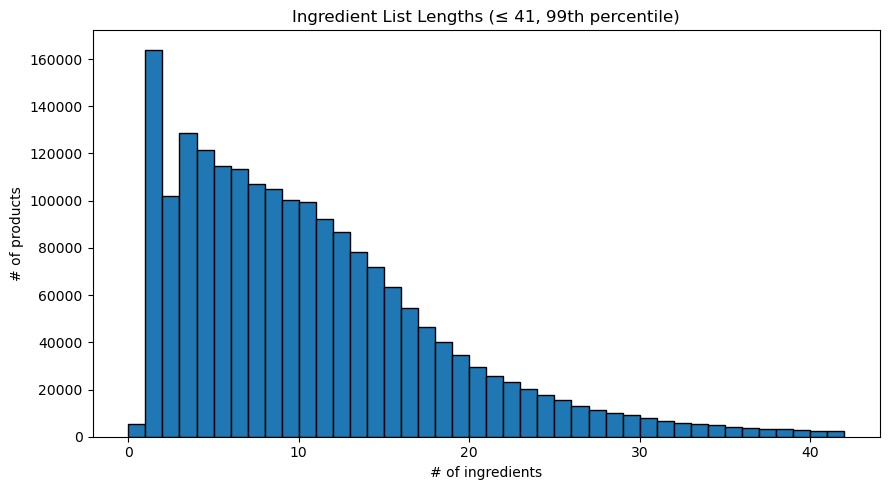

In [8]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

p99 = int(np.ceil(df["num_ingredients"].quantile(0.99)))  # typical max
subset = df.loc[df["num_ingredients"] <= p99, "num_ingredients"]

plt.figure(figsize=(9,5))
plt.hist(subset, bins=np.arange(0, p99+2, 1), edgecolor="black")
plt.title(f"Ingredient List Lengths (≤ {p99}, 99th percentile)")
plt.xlabel("# of ingredients")
plt.ylabel("# of products")
plt.tight_layout()
plt.savefig(figures / "freq_ingredients.png", dpi=300, bbox_inches="tight")
plt.show()
